# A3-Q3: Combatting Overfitting with Dropout and Regularization

## Preliminaries

In [40]:
# Standard imports
import numpy as np
import torch
import matplotlib.pylab as plt
import copy

#for reproducibility purposes
torch.manual_seed(2025)
np.random.seed(2025)

# Dataset

In [41]:
class DividedPlane(torch.utils.data.Dataset):
    def __init__(self, n=100, noise=0.1, seed=None):
        torch.manual_seed(seed)
        theta = torch.rand((1,))*2.*torch.pi
        a = torch.tensor([torch.cos(theta), torch.sin(theta), 0.1])
        def myfunc(x):
            y = a[0]*x[:,0] + a[1]*x[:,1] + a[2]
            return y
        self.x = torch.rand((n,2))*2. - 1.
        y = myfunc(self.x) + noise*torch.normal( torch.zeros((len(self.x))) )
        self.y = (y>0.).type(torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.y.reshape( (len(self.y),1) )
    
    def plot(self, labels=None, *args, **kwargs): 
        X = self.inputs()
        if labels is None:
            labels = self.targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        if len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')


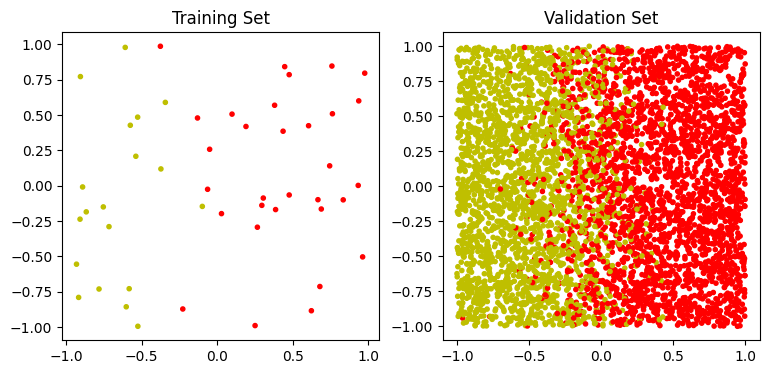

In [42]:
seed = np.random.randint(100000)
train = DividedPlane(n=50, noise=0.25, seed=seed)
validation = DividedPlane(n=5000, noise=0.25, seed=seed)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); train.plot(); plt.title(f'Training Set');
plt.subplot(1,2,2); validation.plot(); plt.title(f'Validation Set');

# (a): `Dropout` layer

In [43]:
class Dropout(torch.nn.Module):
    '''
     lyr = Dropout()
     
     Creates a dropout layer in which each node is set to zero
     with probability lyr.dropprob.
     
     Usage:
       lyr = Dropout()
       lyr.set_dropprob(p) # set the dropout probability to p
       y = lyr(z)          # sets each node to 0 with probability p
    '''
    def __init__(self):
        super().__init__()
        self.dropprob = 0.
        
    def set_dropprob(self, p):
        self.dropprob = p
        
    def forward(self, z):
        # Drop nodes with prob dropprob
        #===== YOUR CODE HERE =====

        return z * torch.empty_like(z).bernoulli_(1 - self.dropprob) / (1 - self.dropprob)

In [44]:
# Test for Dropout layer
z = torch.ones((3,1000))
drop_layer = Dropout()
drop_layer.set_dropprob(0.75)
y = drop_layer(z)
drop_fraction = (torch.sum(y==0.)*100.)/torch.numel(y)
print(f'Dropped {drop_fraction:.1f}%')
print(f'Expected output is {torch.sum(y)}, which should be close to {torch.sum(z)}')

Dropped 74.6%
Expected output is 3044.0, which should be close to 3000.0


# (b): `RobustNetwork`

In [45]:
class RobustNetwork(torch.nn.Module):
    def __init__(self, nodes=100):
        super().__init__()
        self.lyrs = torch.nn.ModuleList()
        self.lyrs.append(torch.nn.Linear(2, nodes//2))
        self.lyrs.append(torch.nn.Tanh())
        self.drop_lyr1 = Dropout()
        self.lyrs.append(self.drop_lyr1)
        self.lyrs.append(torch.nn.Linear(nodes//2, nodes))
        self.lyrs.append(torch.nn.Tanh())
        self.drop_lyr2 = Dropout()   
        self.lyrs.append(self.drop_lyr2)  
        self.lyrs.append(torch.nn.Linear(nodes, 1))
        self.lyrs.append(torch.nn.Sigmoid())
        self.loss_fcn = torch.nn.BCELoss(reduction='mean')
    
    def forward(self, x):
        y = x
        for lyr in self.lyrs:
            y = lyr(y)
        return y
    
    def learn(self, x, t, epochs=100, lr=0.1, l2_lambda=0.0):
        losses = []
        for epoch in range(epochs):
            y = self(x)
            data_loss = self.loss_fcn(y.squeeze(), t.squeeze())

            #Add l2 regulaization implementation here

            frob_norm = 0
            for p in self.parameters():
                frob_norm += p.pow(2).sum()

            loss = data_loss + frob_norm * l2_lambda / 2

            losses.append(loss.item())
            self.zero_grad()
            loss.backward()
            with torch.no_grad():
                #replace me for gradient descent updates
                for p in self.parameters():
                    p -= lr * p.grad
        plt.plot(np.array(losses))
        plt.yscale('log'); plt.xlabel('Epochs'); plt.ylabel('Log Loss');

        print(f'Final loss = {loss}')
        return losses
    



# (c) Train and Validation

In [46]:
net_orig = RobustNetwork(nodes=100)

# Duplicate the network for apples-to-apples comparison
net = copy.deepcopy(net_orig) #network without regularization
dnet = copy.deepcopy(net_orig) #network with dropout
l2net = copy.deepcopy(net_orig) #network with l2 regularization

# Set come common parameters
lr = 0.25
n_epochs = 5000

### Train the models

Final loss = 0.0009571656701155007


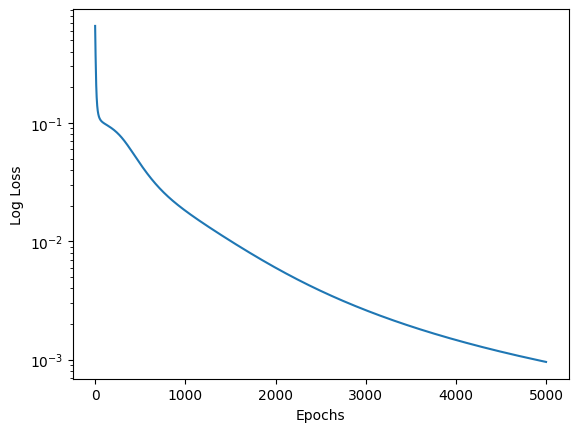

In [47]:
# No effort to guard against overfitting
net.drop_lyr1.dropprob = 0.
net.drop_lyr2.dropprob = 0.
losses = net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr)

Final loss = 0.03012649342417717


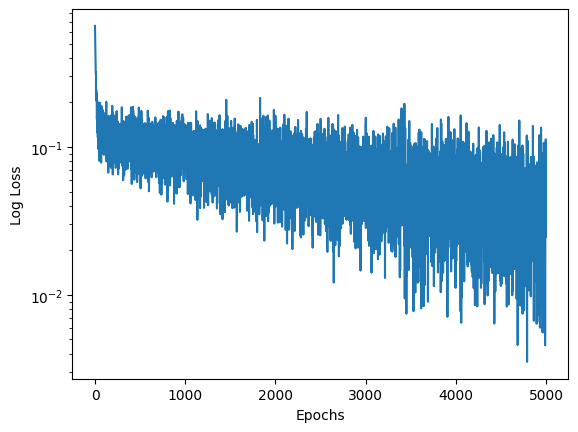

In [48]:
#network with dropout (dnet) training here
dnet.drop_lyr1.dropprob = 0.5
dnet.drop_lyr2.dropprob = 0.5
dlosses = dnet.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr)

Final loss = 0.04822302609682083


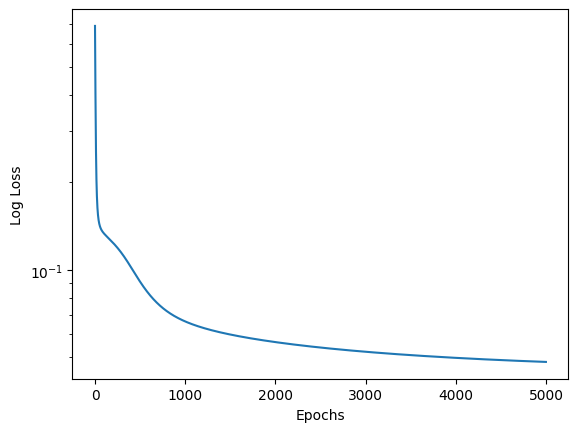

In [49]:


#network with l2 regularization (l2net) training here
l2net.drop_lyr1.dropprob = 0.
l2net.drop_lyr2.dropprob = 0.
l2losses = l2net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr, l2_lambda=1e-3)


### Test the models
#### Let's see what the decision boundaries look like.

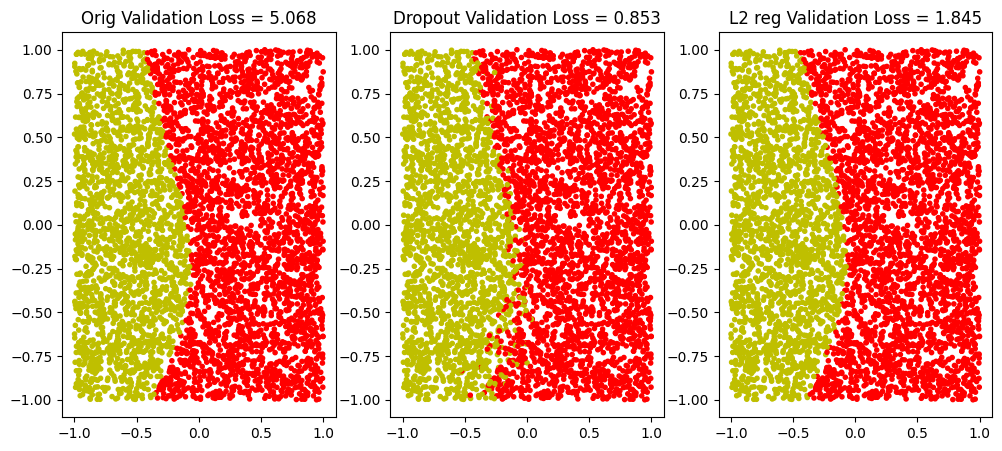

In [54]:

# Compute validation losses here: "validation_loss", "dvalidation_loss", "l2validation_loss

def compute_validation_loss(model, x, t):
    model.eval()
    with torch.no_grad():
        y = model(x)
        val_data_loss = model.loss_fcn(y.squeeze(), t.squeeze()).item()
    return val_data_loss

validation_loss = compute_validation_loss(net, validation.inputs(), validation.targets())
dvalidation_loss = compute_validation_loss(dnet, validation.inputs(), validation.targets())
l2validation_loss = compute_validation_loss(l2net, validation.inputs(), validation.targets())

# Displaying the results
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
#Original model
validation.plot(labels=net(validation.inputs())); plt.title(f'Orig Validation Loss = {validation_loss:.3f}')
plt.subplot(1,3,2)
#Model with dropout
validation.plot(labels=dnet(validation.inputs())); plt.title(f'Dropout Validation Loss = {dvalidation_loss:.3f}');
plt.subplot(1,3,3)
#Model with L2 regularization
validation.plot(labels=l2net(validation.inputs())); plt.title(f'L2 reg Validation Loss = {l2validation_loss:.3f}');

Dropout has the highest training loss but the lowest validation loss, whereas the original model has the lowest training loss but the highest validation loss. This shows that the original model suffered from overfitting and dropout decreased the severity of overfitting dramatically. Dropout has lower validation error than regularization, making it a more desirable choice.